N_SPLITS=10、bagging_fraction=0.7、feature_fraction=0.75のLightGBMモデル（16seed Averaging）

# Libraries

In [ ]:
!pip3 uninstall --yes lightgbm && pip3 install --install-option=--gpu lightgbm

Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 1.5MB 6.0MB/s 
Skipping wheel build for lightgbm, due to binaries being disabled for it.
    Running setup.py install for lightgbm ... done


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import json
import pandas as pd
import numpy as np
import typing as tp
import time
from contextlib import contextmanager
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
import lightgbm as lgb

# Utils

In [ ]:
DATADIR = Path('features')
OUTDIR = Path('stage1')

In [ ]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time.time()
    yield
    d = time.time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "drive/My Drive/probspace_citations"

Mounted at /content/drive
/content/drive/My Drive/probspace_citations


In [ ]:
df = pd.read_csv(DATADIR / 'base_df.csv')
multiple_word_categories_features = pd.read_csv(DATADIR / 'multiple_word_categories_features.csv')
groupby_feat_csv = pd.read_csv(DATADIR / 'groupby_feat.csv')
ALL_w2v = pd.read_csv(DATADIR / 'ALL_w2v.csv')
ALL_svd_fastText = pd.read_csv(DATADIR / 'ALL_svd_fastText.csv')
#ALL_pca_fastText = pd.read_csv(DATADIR / 'ALL_pca_fastText.csv')
ALL_svd_SciBERT = pd.read_csv(DATADIR / 'ALL_svd_SciBERT.csv')
w2v = pd.read_csv(DATADIR / 'w2v.csv')
svd_fastText = pd.read_csv(DATADIR / 'svd_fastText.csv')
#pca_fastText = pd.read_csv(DATADIR / 'pca_fastText.csv')
svd_SciBERT = pd.read_csv(DATADIR / 'svd_SciBERT.csv')
#tfidf = pd.read_csv(DATADIR / 'tfidf.csv')

In [ ]:
df = pd.merge(df, multiple_word_categories_features, on='id', how='left')
df = pd.merge(df, groupby_feat_csv, on='id', how='left')
df = pd.merge(df, ALL_w2v, on='id', how='left')
df = pd.merge(df, ALL_svd_fastText, on='id', how='left')
#df = pd.merge(df, ALL_pca_fastText, on='id', how='left')
df = pd.merge(df, ALL_svd_SciBERT, on='id', how='left')
df = pd.merge(df, w2v, on='id', how='left')
df = pd.merge(df, svd_fastText, on='id', how='left')
#df = pd.merge(df, pca_fastText, on='id', how='left')
df = pd.merge(df, svd_SciBERT, on='id', how='left')
#df = pd.merge(df, tfidf, on='id', how='left')

In [ ]:
drop_cols = [col for col in df.columns[df.T.duplicated()]]
df = df.drop(columns=drop_cols) # 同じ列を削除

df = df.loc[:, df.nunique() > 1] # 1種類の値しかない列を削除

In [ ]:
t = 15117
df_train_exists_cites = df[:t]
df_test = df[t:]

In [ ]:
DROP_COLS = [
    'id',
    'submitter',
    'authors',
    'title',
    'comments',
    'journal-ref',
    'doi',
    'report-no',
    'categories',
    'license',
    'abstract',
    'versions',
    'update_date',
    'authors_parsed',
    'id_feat',
    'doi_feat_2',
]

TGT_COL = "cites"

In [ ]:
X = df_train_exists_cites.drop(columns=DROP_COLS+['cites'])
X_test = df_test.drop(columns=DROP_COLS+['cites'])
y = np.log1p(df_train_exists_cites[TGT_COL])

print(f"train_feat: {X.shape}, test_feat: {X_test.shape}")

train_feat: (15117, 888), test_feat: (59084, 888)


# 1st Stage Model

## Class

In [ ]:
class TreeModel:
    """Wrapper for LightGBM/XGBoost/CATBoost"""
    def __init__(self, model_type: str):
        self.model_type = model_type
        self.trn_data = None
        self.val_data = None
        self.model = None

    def train(self,
              params: dict,
              X_train: pd.DataFrame, y_train: np.ndarray,
              X_val: pd.DataFrame, y_val: np.ndarray,
              train_weight: tp.Optional[np.ndarray] = None,
              val_weight: tp.Optional[np.ndarray] = None,
              train_params: dict = {}):
        if self.model_type == "lgb":
            self.trn_data = lgb.Dataset(X_train, label=y_train, weight=train_weight)
            self.val_data = lgb.Dataset(X_val, label=y_val, weight=val_weight)
            self.model = lgb.train(params=params,
                                   train_set=self.trn_data,
                                   valid_sets=[self.trn_data, self.val_data],
                                   categorical_feature = CATEGORICAL_COLS,
                                   **train_params)
        elif self.model_type == "xgb":
            self.trn_data = xgb.DMatrix(X_train, y_train, weight=train_weight)
            self.val_data = xgb.DMatrix(X_val, y_val, weight=val_weight)
            self.model = xgb.train(params=params,
                                   dtrain=self.trn_data,
                                   evals=[(self.trn_data, "train"), (self.val_data, "val")],
                                   **train_params)
        elif self.model_type == "cat":
            self.trn_data = Pool(X_train, label=y_train, group_id=[0] * len(X_train))
            self.val_data =  Pool(X_val, label=y_val, group_id=[0] * len(X_val))
            self.model = CatBoost(params)
            self.model.fit(
                self.trn_data, eval_set=[self.val_data], use_best_model=True, **train_params)
        else:
            raise NotImplementedError

    def predict(self, X: pd.DataFrame):
        if self.model_type == "lgb":
            return self.model.predict(
                X, num_iteration=self.model.best_iteration)
        elif self.model_type == "xgb":
            X_DM = xgb.DMatrix(X)
            return self.model.predict(
                X_DM, ntree_limit=self.model.best_ntree_limit)
        elif self.model_type == "cat":
            return self.model.predict(X)
        else:
            raise NotImplementedError

    @property
    def feature_names_(self):
        if self.model_type == "lgb":
            return self.model.feature_name()
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").keys())
        elif self.model_type == "cat":
             return self.model.feature_names_
        else:
            raise NotImplementedError

    @property
    def feature_importances_(self):
        if self.model_type == "lgb":
            return self.model.feature_importance(importance_type="gain")
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").values())
        elif self.model_type == "cat":
            return self.model.feature_importances_
        else:
            raise NotImplementedError

In [ ]:
CATEGORICAL_COLS = [
    'doi_feat',
]

N_SPLITS = 10
RANDOM_SEED_LIST_LGB = [250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265]
RANDOM_SEED_LIST_XGB = [131,134,135,136,137,138]
RANDOM_SEED_LIST_CAT = [310,311,312,313,314,315]

MODEL_PARAMS = {
    "lgb": {
        'seed': RANDOM_SEED_LIST_LGB[1],
        'learning_rate': 0.01,
        'bagging_fraction': 0.7,
        'bagging_freq': 7,
        'feature_fraction': 0.7,
        'feature_pre_filter': False,
        'lambda_l1': 5.303273671011905e-07,
        'lambda_l2': 0.0036041492368018907,
        'metric': 'rmse',
        'min_child_samples': 24,
        'num_leaves': 36,
        'max_bin': 63,
        'objective': 'regression',
        'verbosity': -1,
        'device': 'gpu',
        'gpu_device_id': 0,
    },
}

TRAIN_PARAMS = {
    "lgb": {
        "num_boost_round": 20000,
        "early_stopping_rounds": 200,
        "verbose_eval": 100,
    },
}

In [ ]:
def target_stratify_kfold(df, seed,n_bins=N_SPLITS*100, folds=N_SPLITS):
    _df = pd.DataFrame()
    _df["bins"] = pd.cut(df.cites, n_bins, labels=False)
    fold = np.zeros(len(df), dtype=int)
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for i_fold, (_, val_idx) in enumerate(skf.split(_df.bins, _df.bins)):
        fold[val_idx] = i_fold
    return fold

In [ ]:
def run_train_and_inference(X, X_test, y, use_model, model_params, train_params, seed_list, n_splits):
    
    oof_pred_arr = np.zeros(len(X))
    test_pred_arr = np.zeros(len(X_test))
    feature_importances = pd.DataFrame()
    score_list = []
    
    for seed in seed_list:
        if use_model == "cat":
            model_params['random_state'] = seed
        else:
            model_params["seed"] = seed
        folds_idx = target_stratify_kfold(df=df_train_exists_cites, seed=seed)
        tmp_oof_pred = np.zeros(len(X))
        tmp_test_pred = np.zeros(len(X_test))

        for fold in range(N_SPLITS):
            tr_idx = np.argwhere(folds_idx != fold).reshape(-1)
            va_idx = np.argwhere(folds_idx == fold).reshape(-1)
            X_trn, X_val = X.loc[tr_idx], X.loc[va_idx]
            y_trn, y_val = y.loc[tr_idx], y.loc[va_idx]

            model = TreeModel(model_type=use_model)
            with timer(prefix="Model training"):
                model.train(
                    params=model_params, X_train=X_trn, y_train=y_trn,
                    X_val=X_val, y_val=y_val, train_params=train_params)
            fi_tmp = pd.DataFrame()
            fi_tmp["feature"] = model.feature_names_
            fi_tmp["importance"] = model.feature_importances_
            fi_tmp["fold"] = fold
            fi_tmp["seed"] = seed
            feature_importances = feature_importances.append(fi_tmp)

            val_pred = model.predict(X_val)
            score = mean_squared_error(y_val, val_pred, squared=False)
            print(f"score: {score:.5f}")
            score_list.append([seed, fold, score])
            tmp_oof_pred[va_idx] = val_pred
            tmp_test_pred += model.predict(X_test)
            
        oof_score = mean_squared_error(y, tmp_oof_pred, squared=False)
        print(f"oof score: {oof_score: 5f}")
        score_list.append([seed, "oof", oof_score])

        oof_pred_arr += tmp_oof_pred
        test_pred_arr += tmp_test_pred / n_splits

    oof_pred_arr /= len(seed_list)
    test_pred_arr /= len(seed_list)
    
    oof_score = mean_squared_error(y, oof_pred_arr, squared=False)
    score_list.append(["avg", "oof", oof_score])
    score_df = pd.DataFrame(
        score_list, columns=["seed", "fold", "rmse score"])
    
    return oof_pred_arr, test_pred_arr, score_df, feature_importances

## LightGBM

In [ ]:
oof_pred_lgb, test_pred_lgb, score_lgb, feat_imps_lgb = run_train_and_inference(
    X, X_test, y, "lgb", MODEL_PARAMS["lgb"], TRAIN_PARAMS["lgb"], RANDOM_SEED_LIST_LGB, N_SPLITS)

Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.646174	valid_1's rmse: 0.648487
[200]	training's rmse: 0.502389	valid_1's rmse: 0.516158
[300]	training's rmse: 0.456262	valid_1's rmse: 0.485622
[400]	training's rmse: 0.429652	valid_1's rmse: 0.474828
[500]	training's rmse: 0.409241	valid_1's rmse: 0.469909
[600]	training's rmse: 0.391586	valid_1's rmse: 0.467436
[700]	training's rmse: 0.37568	valid_1's rmse: 0.466054
[800]	training's rmse: 0.361087	valid_1's rmse: 0.465518
[900]	training's rmse: 0.347325	valid_1's rmse: 0.464923
[1000]	training's rmse: 0.334704	valid_1's rmse: 0.464199
[1100]	training's rmse: 0.322958	valid_1's rmse: 0.464245
[1200]	training's rmse: 0.311543	valid_1's rmse: 0.464486
Early stopping, best iteration is:
[1021]	training's rmse: 0.332274	valid_1's rmse: 0.463935
Model training50.852[s]
score: 0.46393
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.643543	valid_1's rmse: 0.661215
[

In [ ]:
score_lgb.loc[score_lgb.fold == "oof"]

,seed,fold,rmse score
10,250,oof,0.487603
21,251,oof,0.487624
32,252,oof,0.487037
43,253,oof,0.487707
54,254,oof,0.487491
65,255,oof,0.487615
76,256,oof,0.487327
87,257,oof,0.488407
98,258,oof,0.488087
109,259,oof,0.486893


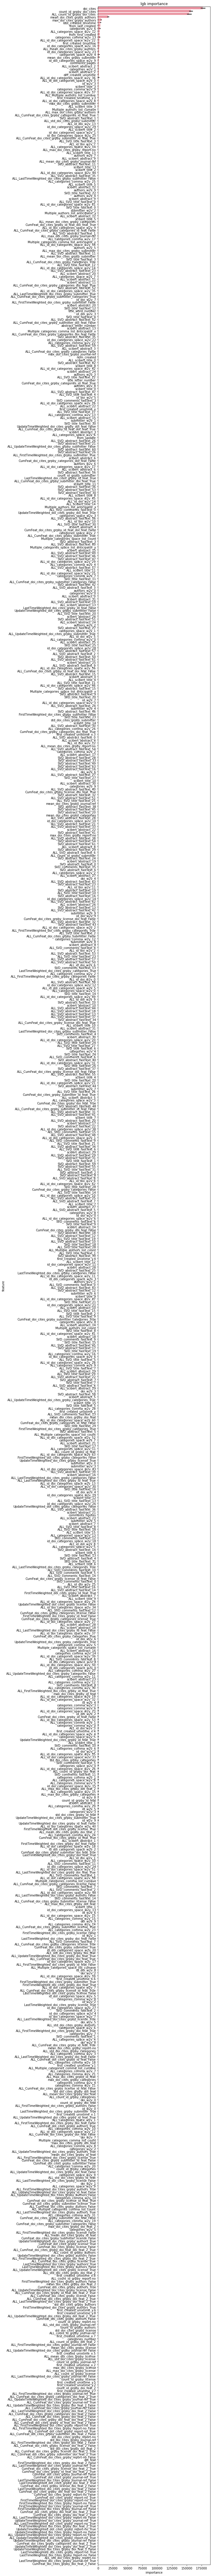

In [ ]:
order = list(feat_imps_lgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 120))
sns.barplot(x="importance", y="feature", data=feat_imps_lgb, order=order)
plt.title("{} importance".format("lgb"))
plt.tight_layout()

In [ ]:
stage1 = pd.read_csv(OUTDIR / 'stage1.csv')
stage1['pred_888feat_lgb2'] = np.nan
stage1['pred_888feat_lgb2'][:t] = oof_pred_lgb
stage1['pred_888feat_lgb2'][t:] = test_pred_lgb
stage1.to_csv(OUTDIR / 'stage1.csv', index=False)

In [ ]:
output = np.expm1(test_pred_lgb)
df_sub = pd.DataFrame()
df_sub["id"] = df_test["id"]
df_sub["cites"] = output
df_sub.to_csv(OUTDIR / 'stage1_888feat_lgb2.csv', index=False)